# Permutation Tests

Permutation tests are exact statistical tests. We can use them to test whether
two groups of cells came from the same distribution. This can be a valueable tool
when we want to assess if a treatment had a significant effect on the transcript profiles of the cells.
Pertpy offers a flexible implementation of Monte-Carlo Permutation Tests that
can use any of the implemented distance functions as a test statistic.

In [195]:
import scanpy as sc
import numpy as np
import pertpy as pt
import matplotlib.pyplot as plt

# Data

In [196]:
adata = pt.dt.dixit_2016_scperturb()
obs_key = 'perturbation'  # defines groups to test
contrast = 'control'  # defines contrast group for test

In [197]:
adata.layers['counts'] = adata.X.copy()

# basic qc and pp
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.log1p(adata)

# subsample against high class imbalance
N_min = 100
counts = adata.obs[obs_key].value_counts()
groups = counts.index[counts>=N_min]
indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N_min, replace=False) for group in groups]
selection = np.hstack(np.array(indices))
adata = adata[selection].copy()
sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

# select HVGs
n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.pca(adata, use_highly_variable=True)

In [184]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)

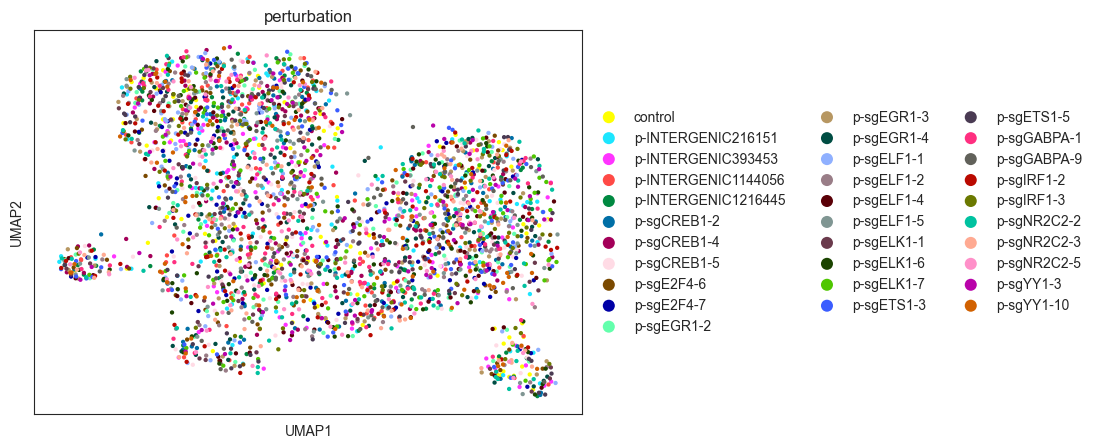

In [185]:
sc.pl.scatter(adata, basis='umap', color=obs_key, show=True)

# E-test (uses E-distance)

In [186]:
etest = pt.tl.PermutationTest('edistance', n_perms=1000, obsm_key='X_pca', alpha=0.05, correction='holm-sidak')
tab = etest(adata, groupby=obs_key, contrast=contrast)

Output()

In [187]:
# test results
tab.head()

,distance,pvalue,significant,pvalue_adj,significant_adj
control,0.000000,1.000,False,1.000000,False
p-sgELF1-5,0.259962,0.004,True,0.058349,False
p-sgYY1-3,0.278695,0.031,True,0.172167,False
p-sgNR2C2-5,0.178451,0.002,True,0.043088,True
p-sgNR2C2-3,0.200028,0.037,True,0.172167,False


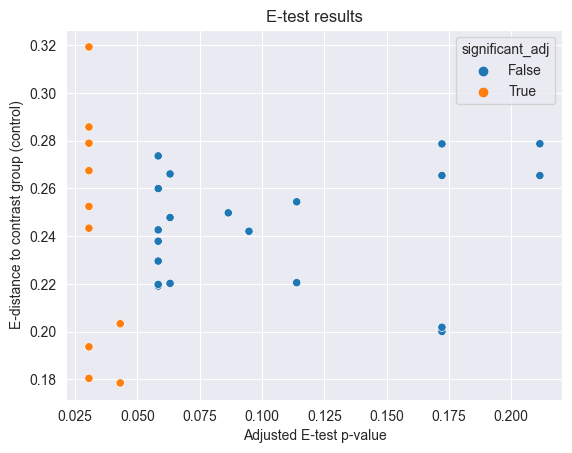

In [191]:
import seaborn as sns
with sns.axes_style('darkgrid'):
    sns.scatterplot(data=tab[tab.index!=contrast], x='pvalue_adj', y='distance', hue='significant_adj')
plt.title('E-test results')
plt.xlabel('Adjusted E-test p-value')
plt.ylabel('E-distance to contrast group (control)')
plt.show()